This jupyter notebook contains demo code for:
- loading a model and using it to 
- drive one or more source frames with a set of driving frames
- modifying the embedded face to perform video editing for both the dragon tattoo and Harry Potter scar

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import os
import torch
from PIL import Image
from torch.autograd import Variable
from UnwrappedFace import UnwrappedFaceWeightedAverage, UnwrappedFaceWeightedAveragePose
import torchvision
from torchvision.transforms import ToTensor, Compose, Scale

In [2]:
torch. __version__ 

'1.7.1'

In [3]:
def run_batch(source_images, pose_images):
    return model(pose_images, *source_images)

In [4]:
BASE_MODEL = '../release_models/' # Change to your path
state_dict = torch.load(BASE_MODEL + 'x2face_model_forpython3.pth', map_location=torch.device('cpu'))

model = UnwrappedFaceWeightedAverage(output_num_channels=2, input_num_channels=3, inner_nc=128)
model.load_state_dict(state_dict['state_dict'])
# model = model.cuda()

model = model.eval()

initialization method [xavier]


/Users/loggcheng/fyp_fast/X2Face-master/UnwrapMosaic/SkipNet.py:72: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data, gain=1)
/Users/loggcheng/fyp_fast/X2Face-master/UnwrapMosaic/SkipNet.py:76: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  init.uniform(m.weight.data, 0.02, 1)
/Users/loggcheng/fyp_fast/X2Face-master/UnwrapMosaic/SkipNet.py:77: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias.data, 0.0)


initialization method [xavier]


/Users/loggcheng/fyp_fast/X2Face-master/UnwrapMosaic/NoSkipNet_X2Face.py:32: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data, gain=1)
/Users/loggcheng/fyp_fast/X2Face-master/UnwrapMosaic/NoSkipNet_X2Face.py:37: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  init.uniform(m.weight.data, 0.02, 1.0)
/Users/loggcheng/fyp_fast/X2Face-master/UnwrapMosaic/NoSkipNet_X2Face.py:38: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias.data, 0.0)


**Code for driving with another set of frames**

In [5]:
driver_path = './examples/Taylor_Swift/1.6/nuBaabkzzzI/'
source_path = './examples/Taylor_Swift/1.6/vBgiDYBCuxY/'

driver_imgs = [driver_path + d for d in sorted(os.listdir(driver_path))][0:8] # 8 driving frames
source_imgs  = [source_path + d for d in sorted(os.listdir(source_path))][0:3] # 3 source frames

In [6]:
def load_img(file_path):
    img = Image.open(file_path)
    transform = Compose([Scale((256,256)), ToTensor()])
    return Variable(transform(img))
    # return Variable(transform(img)).cuda()

/opt/anaconda3/envs/fyp/lib/python3.8/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/opt/anaconda3/envs/fyp/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


The results is: 


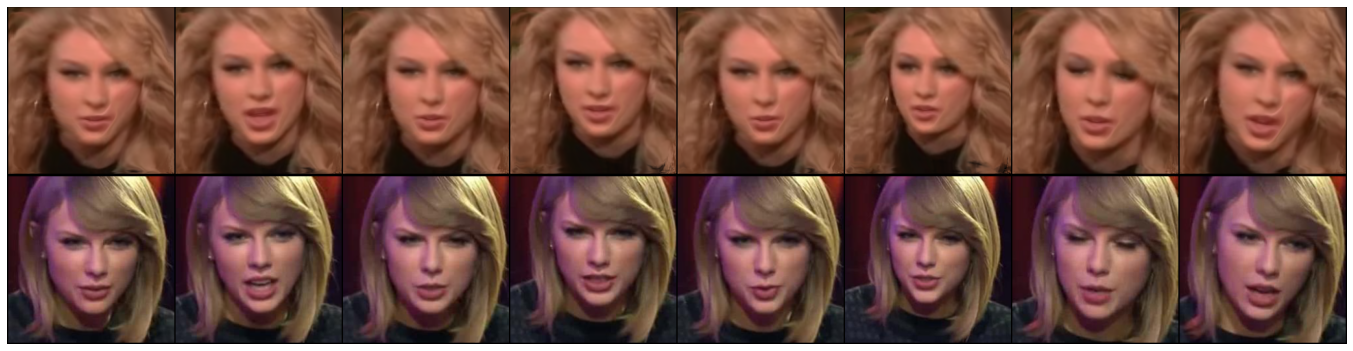

In [7]:
# Driving the source image with the driving sequence
source_images = []
for img in source_imgs:
    source_images.append(load_img(img).unsqueeze(0).repeat(len(driver_imgs), 1, 1, 1))
    
driver_images = None
for img in driver_imgs:
    if driver_images is None:
        driver_images = load_img(img).unsqueeze(0)
    else:
        driver_images = torch.cat((driver_images, load_img(img).unsqueeze(0)), 0)

# Run the model for each
with torch.no_grad():
    result = run_batch(source_images, driver_images)
result = result.clamp(min=0, max=1)
img = torchvision.utils.make_grid(result.cpu().data)
    
# Visualise the results
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24.
fig_size[1] = 24.
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')

result_images = img.permute(1,2,0).numpy()
driving_images = torchvision.utils.make_grid(driver_images.cpu().data).permute(1,2,0).numpy()
print("The results is: ")
plt.imshow(np.vstack((result_images, driving_images)))

**Code for using the dragon tattoo to modify the unwrapped mosaic**

The tattoo: 


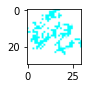

In [9]:
# Generate the dragon tattoo
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 1.
fig_size[1] = 1.
plt.rcParams["figure.figsize"] = fig_size

tattoo = Image.open('./tattoos/dragon_tattoo.png')
tattoo = tattoo.resize((30,30), Image.BILINEAR).rotate(45).convert('RGBA')

b, g, r, a = tattoo.split()
tattoo = Image.merge("RGBA", (g, b, r, a))
tattoo_flipped = tattoo.transpose(Image.FLIP_LEFT_RIGHT)

tattoo = np.array(tattoo) / 256.
tattoo[:,:,[1,2]] = 1
tattoo_flipped = np.array(tattoo_flipped) / 256.
tattoo_flipped[:,:,[1,2]] = 1
print("The tattoo: ")
plt.imshow(tattoo)

# Add a flipped version to make a moustache
tattoo = torch.Tensor(tattoo)
tattoo_flipped = torch.Tensor(tattoo_flipped)
tattoo = tattoo.permute(2,0,1)
tattoo_flipped = tattoo_flipped.permute(2,0,1)

# Changes the colour
# alpha = tattoo[3:4,:,:].cuda()
# tattoo = tattoo[0:3,:,:].cuda()
# alpha_flipped = tattoo_flipped[3:4,:,:].cuda()
# tattoo_flipped = tattoo_flipped[0:3,:,:].cuda()
alpha = tattoo[3:4,:,:]
tattoo = tattoo[0:3,:,:]
alpha_flipped = tattoo_flipped[3:4,:,:]
tattoo_flipped = tattoo_flipped[0:3,:,:]

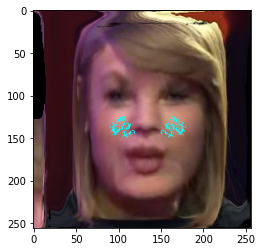

In [13]:
# Reload driving / source frames
driver_path = './examples/Taylor_Swift/1.6/nuBaabkzzzI/'
source_path = './examples/Taylor_Swift/1.6/nuBaabkzzzI/'

driver_imgs = [driver_path + d for d in sorted(os.listdir(driver_path))][0:8] # 8 driving frames
source_imgs  = [source_path + d for d in sorted(os.listdir(source_path))][0:1] # 1 source frames

source_images = []
for img in source_imgs:
    source_images.append(load_img(img).unsqueeze(0))
    
driver_images = None
for img in driver_imgs:
    if driver_images is None:
        driver_images = load_img(img).unsqueeze(0)
    else:
        driver_images = torch.cat((driver_images, load_img(img).unsqueeze(0)), 0)

        
# Modify the face with the given tattoo 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 4.
fig_size[1] = 4.
plt.rcParams["figure.figsize"] = fig_size

# Get the unwrapped face
with torch.no_grad():
    sampler = model.pix2pixUnwrapped(*source_images)[0][:,0:2,:,:]
    xs = np.linspace(-1,1,256)
    xs = np.meshgrid(xs, xs)  
    xs = np.stack(xs, 2) 
    # xs = torch.Tensor(xs).unsqueeze(0).repeat(1, 1,1,1).cuda()
    xs = torch.Tensor(xs).unsqueeze(0).repeat(1, 1,1,1)
    sampler = nn.Tanh()(sampler).permute(0,2,3,1) + Variable(xs)

# Visualise unwrapped face with tattoo
result = nn.functional.grid_sample(source_images[0],  sampler).squeeze().cpu()
alpha = alpha.cpu()
tattoo = tattoo.cpu()
to_copy = tattoo * alpha.float() + (1 - alpha.float()) * result[:,125:155,90:120].data.cpu()
# to_copy = Variable(to_copy).cuda()
to_copy = Variable(to_copy)
result[:,125:155,90:120] = to_copy

alpha_flipped = alpha_flipped.cpu()
tattoo_flipped = tattoo_flipped.cpu()
to_copy = tattoo_flipped * alpha_flipped.float() + (1 - alpha_flipped.float()) * result[:,125:155,150:180].data.cpu()
# to_copy = Variable(to_copy).cuda()
to_copy = Variable(to_copy)
result[:,125:155,150:180] = to_copy
plt.imshow(result.data.squeeze().cpu().permute(1,2,0).numpy())

The unwrapped mosaic driven with the given face is: 


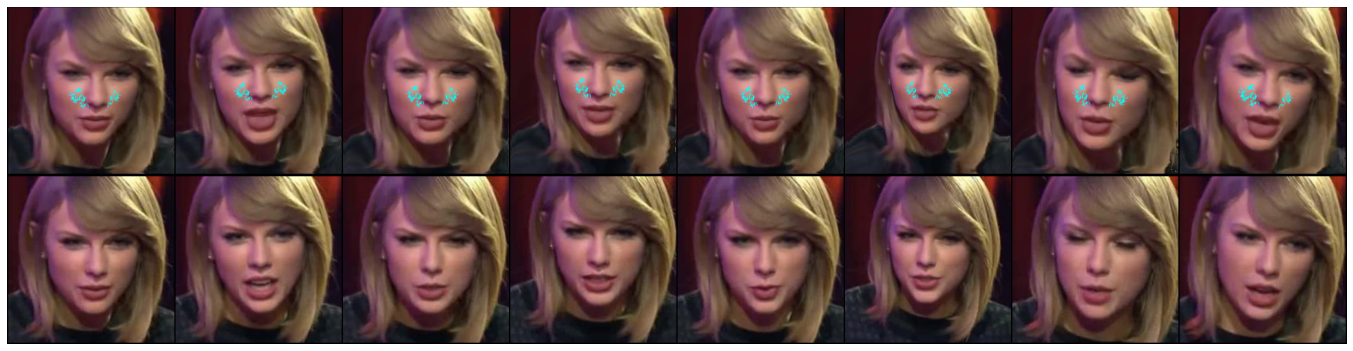

In [14]:
# Run the model for each
with torch.no_grad():
    output_sampler = model.pix2pixSampler(driver_images)[0]
    output_sampler = nn.Tanh()(output_sampler).permute(0,2,3,1) + Variable(xs)
    result = nn.functional.grid_sample(result.unsqueeze(0).repeat(output_sampler.size(0), 1, 1, 1), 
                                       output_sampler.cpu()).squeeze()
    
result = result.clamp(min=0, max=1)
img = torchvision.utils.make_grid(result.cpu().data)
    
# Visualise the results
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24.
fig_size[1] = 24.
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')

result_images = img.permute(1,2,0).numpy()
driving_images = torchvision.utils.make_grid(driver_images.cpu().data).permute(1,2,0).numpy()
print("The unwrapped mosaic driven with the given face is: ")
plt.imshow(np.vstack((result_images, driving_images)))

**Code for using the Harry Potter scar to modify the unwrapped mosaic**

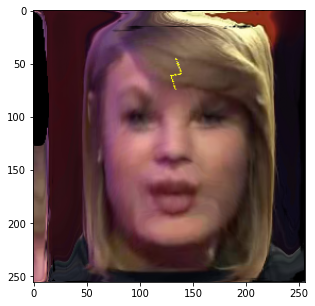

In [16]:
# Generat the tattoo for the hp scar
index = 7
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 1.
fig_size[1] = 1.
plt.rcParams["figure.figsize"] = fig_size
from PIL import Image
tattoo = Image.open('./tattoos/hp_scar_2.png')
tattoo = tattoo.resize((30,30), Image.BILINEAR).rotate(45).convert('RGBA')
b, g, r, a = tattoo.split()
tattoo = Image.merge("RGBA", (g, b, r, a))

tattoo = np.array(tattoo) / 256.
tattoo[:,:,[0,1]] = 1
tattoo = torch.Tensor(tattoo)
tattoo = tattoo.permute(2,0,1)
alpha = tattoo[2,:,:] < 0.9
tattoo = tattoo[0:3,:,:]

# Graph the result concatenated with the original frame across a sequence of frames : does the expression change?
# Match the 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 4.
fig_size[1] = 4.
plt.rcParams["figure.figsize"] = (5,5)

# Get the unwrapped face
with torch.no_grad():
    sampler = model.pix2pixUnwrapped(*source_images)[0][:,0:2,:,:]
    xs = np.linspace(-1,1,256)
    xs = np.meshgrid(xs, xs)  
    xs = np.stack(xs, 2) 
    # xs = torch.Tensor(xs).unsqueeze(0).repeat(1, 1,1,1).cuda()
    xs = torch.Tensor(xs).unsqueeze(0).repeat(1, 1,1,1)
    sampler = nn.Tanh()(sampler).permute(0,2,3,1) + Variable(xs)
    result = nn.functional.grid_sample(source_images[0],  sampler).squeeze()

alpha = alpha.float().clamp(max=1.0) # modify to make more/less realistic
to_copy = tattoo * alpha.float() + (1 - alpha.float()) * result[:,45:75,120:150].data.cpu()
# to_copy = Variable(to_copy).cuda()
to_copy = Variable(to_copy)
result[:,45:75,120:150] = to_copy
plt.imshow(result.data.squeeze().cpu().permute(1,2,0).numpy())

The unwrapped mosaic driven with the given face is: 


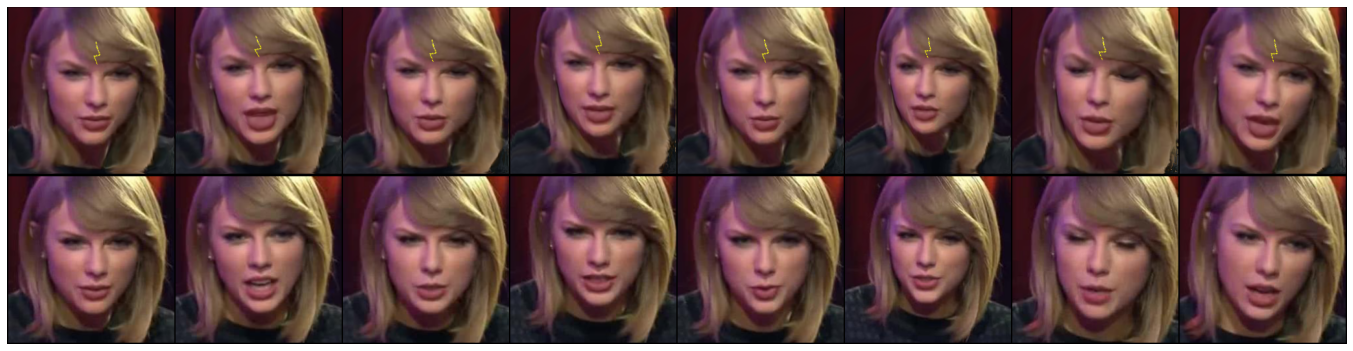

In [17]:
# Run the model for each
with torch.no_grad():
    output_sampler = model.pix2pixSampler(driver_images)[0]
    output_sampler = nn.Tanh()(output_sampler).permute(0,2,3,1) + Variable(xs)
    result = nn.functional.grid_sample(result.unsqueeze(0).repeat(output_sampler.size(0), 1, 1, 1).cpu(), 
                                       output_sampler.cpu()).squeeze()
    
result = result.clamp(min=0, max=1)
img = torchvision.utils.make_grid(result.cpu().data)
    
# Visualise the results
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24.
fig_size[1] = 24.
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')

result_images = img.permute(1,2,0).numpy()
driving_images = torchvision.utils.make_grid(driver_images.cpu().data).permute(1,2,0).numpy()
print("The unwrapped mosaic driven with the given face is: ")
plt.imshow(np.vstack((result_images, driving_images)))